# Stæ & rei – Fyrirlestraræfing 8 – Lausnir

In [1]:
#BYRJA -- Keyrið til að frumstilla.
import numpy as np, numpy.random as npr, numpy.linalg as la
import scipy.stats as stat, statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
%matplotlib inline
# disp(x,y...) skrifar x,y... með 3 aukastöfum
def disp(*args): print(*(f'{a:.3f}' if isinstance(a,float) else a for a in args))
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)

## 1. Ýmis vigurföll
Við byrjum á að rifja upp/reikna aftur seinni hlutann af tímadæmum 7.

**a**) Fjarlægð milli tveggja punkta, $a$ og $b$ er gefin með $\|a - b\|$. Hana má reikna $\| x \|$ með `la.norm(x)` (þar sem `numpy.linalg` er flutt inn sem `la`). Reiknið fjarlægðina milli $(1,2,3)$ og $(4,6,15)$.

**b)** Meðaltal og staðalfrávik vigurs `x` má reikna með `np.mean(x)` og `np.std(x)`. Lesið inn upplýsingar um körfuboltamennina (úr skránni `karfa.txt`) með skipuninni `[aldur, hæð, þyngd] = np.loadtxt('karfa.txt').T` og reiknið meðaltal og staðalfrávik þyngdar þeirra og sömuleiðis hæðar.

**c)** Dreifni vigurs er staðalfrávik hans í öðru veldi og hana má reikna með `np.var(x)`. Reiknið dreifni hæðar körfuboltamannanna og sannreynið að kvaðratrótin af henni sé jöfn staðalfrávikinu.

**d)** Hornið milli $x$ og $y$ er $\arccos \frac{x^T y}{\|x\| \|y\|}$. Reiknið hornið milli $(1,1,1)$ og $(1,2,3)$. Munið að $x^Ty$ ($=x\cdot y$) má reikna með `x @ y`. 

**Sjá lausn á Tímadæmum 7**

## 2. Fjarlægð milli Reykjavíkur og London
Þetta var líka á tímadæmunum en hér er það hálfreiknað og þarf bara að klára. Vigur með kúluhnit $(R, l, b)$ er

$$\pmatrix{R\sin l \cos b\\R\cos l \cos b\\R\sin b}$$

Hér getur $R$ verið radíus jarðar, $R \approx 6370\ \text{km}$, og $l$ og $b$ hnattstaða (lengd og breidd). Lengd hringboga í hring með radíus $R$ sem spannar horn sem er $\theta$ radíanar er $L = r\theta.$ Reiknið fjarlægðina milli Reykjavíkur (64°N og 22°E) og London (51.5°N og 0°W) (Siri segir 1890 km), sbr. dæmi 1d. 

[*Á Wikipediu er [grein með myndum](https://en.wikipedia.org/wiki/Great-circle_distance) sem má skoða og hér er önnur [um boga](https://en.wikipedia.org/wiki/Arc_(geometry)), og svo er líka mynd á bls. 59 í kennslubók.*]

In [2]:
def sind(x): return np.sin(np.radians(x))  # sin(x°) 
def cosd(x): return np.cos(np.radians(x))  # cos(x°)
R = 6370
bRvk = 64
lRvk = -22
bLondon = 51.5
lLondon = 0
x = np.array([
    R*sind(lRvk)*cosd(bRvk),
    R*cosd(lRvk)*cosd(bRvk),
    R*sind(bRvk)
])
y = np.array([
    R*sind(lLondon)*cosd(bLondon),
    R*cosd(lLondon)*cosd(bLondon),
    R*sind(bLondon)
])
theta = np.arccos((x@y)/(la.norm(x)*la.norm(y)))
D = R*theta
disp(D)

1887.395


## 3. Jafna besta plans
Byrjum á að skoða (rifja upp) ákvörðun á jöfnu besta plans. Í þessu [stackoverflow-svari](
https://stackoverflow.com/questions/47344850/scatterplot3d-regression-plane-with-residuals) eru myndir sem gæti verið gagnlegt að skoða.

Í reitnum hér á eftir eru búin til gervigögn sem gætu t.d. lýst hæð 5–15 ára trjáa sem fall af aldri þeirra og hæð yfir sjó: trén hækka um einn metra á ári, en lækka um 1 m fyrir hverja 100 m sem þau standa hærra uppi í brekkunni:

$$
\text{hæð}_i = a_0 + a_1 x_i + a_2 y_i + {\varepsilon}_i\ \ (a_0 = 0.5, a_1 = 1, a_2 = -0.01)
$$

þar sem $x_i$ er aldur og $y_i$ er hys fyrir tré $i$.

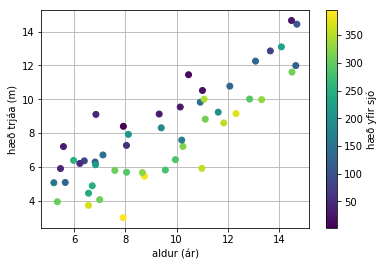

In [3]:
npr.seed(42)
aldur = 5 + npr.rand(50)*10
hys = npr.rand(50)*400
eps = npr.randn(50)
hæð = 0.5 + 1*aldur - 0.01*hys + eps
plt.scatter(aldur, hæð, c=hys)
plt.xlabel('aldur (ár)')
plt.ylabel('hæð trjáa (m)')
plt.colorbar(label='hæð yfir sjó')
plt.grid()

Nú skal meta stika líkansins með því að beita "venjulegri aðferð minnstu kvaðrata", þ.e.a.s. með því að lágmarka kvaðratsummu frávika milli hæðar trjánna og spár líkansins. Með öðrum orðum skal  lágmarka fallið:

$$
S(a_0, a_1, a_2) = \sum_{i=1}^{50} (\text{hæð}_i - (a_0 + a_1 x_i + a_2 y_i))^2
$$

Til þess má nota Python-fallið `sm.OLS` (þar sem `sm` er `statsmodels.api` sem flutt er inn að ofan). `OLS` stendur fyrir *ordinary least squares*. Hér er reitur sem sýnir hvernig:

In [4]:
X = np.c_[aldur, hys]   # Setjum aldur og hys inn í fylki
X = sm.add_constant(X)  # Bætum við dálki af ásum
model = sm.OLS(hæð, X)  # búum til líkan
result = model.fit()    # finnum stika
a = result.params       # Búum til vigur [a_0, a_1, a_2] með stikunum
result.summary()        # Skrifum niðurstöðuna

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     239.7
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           2.20e-25
Time:                        23:08:53   Log-Likelihood:                -62.788
No. Observations:                  50   AIC:                             131.6
Df Residuals:                      47   BIC:                             137.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8598      0.463      4.016      0.000       0.928       2.791
x1             0.8671      0.043     19.974      0.000       0.780       0.954
x2            -0.0104      0.001    -10.199      0.000      -0.012      -0.008
==============================================================================
Omnibus:                        1.624   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                0.982
Skew:                           0.327   Prob(JB):                        0.612
Kurtosis:                       3.211   Cond. No.                         871.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Létt æfing:
Næsti reitur skilgreinir punktasafn $(x_i, y_i, z_i), i=1,\ldots,8$. Ákvarðið jöfnu besta plans í gegn um punktana

**ATH.** Þið þurfið að búa til `X`, bæta við dálki með ásum, búa til `model`, kalla á `fit` og birta líkanið með `summary`.

array([-0.2224,  1.2300,  0.2738])

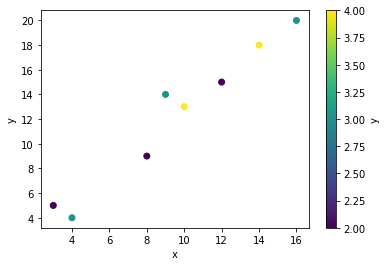

In [5]:
x = np.array([3, 4, 8, 10, 9,  12, 14, 16])
y = np.array([2, 3, 2,  4, 3,   2,  4,  3])
z = np.array([5, 4, 9, 13, 14, 15, 18, 20])
plt.scatter(x,z,c=y)
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar(label='y')
X = np.c_[x, y]
X = sm.add_constant(X)
r = sm.OLS(z,X).fit()
r.params

## 4. Fasteignamat
Í skránni `íbúðasölur.txt` eru upplýsingar um söluverð á 100 íbúðum ásamt upplýsingum um þær, nánar tilekið:
- flatarmál íbúðar
- flatarmál bílskúrs (ef hann fylgir)
- flatarmál svala (ef þær eru)
- hvort íbúðin sé í kjallara ($K$ = 1)
- hvort íbúðin sé á 3. hæð eða hærra án lyftu ($H$ = 1). 

Verkefnið snýst um að búa til fasteignamatslíkan sem er svona:

$$
\log_{10}(\text{söluverð}) 
= \text{fasti} + a_1 \log_{10}(\text{flm})
+ a_2 \frac{\text{bílskf}}{\text{flm}} 
+ a_3 \frac{\text{svalf}}{\text{flm}} + a_4 K +a_5 H
$$

Fastinn og stikarnir $a_1,\ldots, a_5$ skulu valdir þannig að summa kvaðrata mismunarins milli $log_{10}(\text{söluverð})$ og líkansins verði sem minnst, eins og í F7.1.

a) Lesið inn skrána inn í sex vigra.<br>
b) Búið til nokkur súlurit og/eða skatterplott af gögnunum.<br>
c) Ákvarðið minnstu kvaðrata líkan útfrá gögnunum (eins og gert var í dæmi 3)<br>

Að þessu loknu skulum við skoða [skýrslu á vef Þjóðskrár](https://www.skra.is/library/Samnyttar-skrar-/Um-okkur/Fasteigna-og-brunabotamatsskyrslur/Skýrsla%20um%20fasteignamat%202018.pdf), en á bls. 25 eru sýnd núgildandi fasteignamatslíkön. Það er reyndar líkan af söluverðinu sjálfu, en ekki logranum af því. Skoðum það betur í fyrirlestri.

In [6]:
(sv,flm,bílskf,svalf,K,H) = np.loadtxt('íbúðasölur.txt',skiprows=1).T
n = len(sv)
y = np.log10(sv)
X = np.c_[np.log10(flm), bílskf/flm, svalf/flm, K, H]
X = sm.add_constant(X)
model = sm.OLS(y, X)
res = model.fit()
disp(res.summary())
res.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     351.7
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           3.33e-59
Time:                        23:08:54   Log-Likelihood:                 221.85
No. Observations:                 100   AIC:                            -431.7
Df Residuals:                      94   BIC:                            -416.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1591      0.040      4.005      0.0

array([ 0.1591,  0.7285,  0.1970,  0.0643, -0.0405, -0.0168])